In [ ]:
# DFA for simplified English words

def dfa_validate(word):
    state = 0  # start state
    for i, ch in enumerate(word):
        if state == 0:
            # First character must be lowercase a-z
            if 'a' <= ch <= 'z':
                state = 1
            else:
                return False
        elif state == 1:
            # Following characters must also be lowercase a-z
            if 'a' <= ch <= 'z':
                state = 1
            else:
                return False
    return state == 1  # must end in valid state


# Test words
test_words = [
    "cat", "dog", "a", "zebra",   # Accepted
    "dog1", "1dog", "DogHouse", "Dog_house", " cats"  # Not accepted
]

# Run DFA and print results
for word in test_words:
    if dfa_validate(word):
        print(f"{word} -> Accepted")
    else:
        print(f"{word} -> Not Accepted")


cat -> Accepted
dog -> Accepted
a -> Accepted
zebra -> Accepted
dog1 -> Not Accepted
1dog -> Not Accepted
DogHouse -> Not Accepted
Dog_house -> Not Accepted
 cats -> Not Accepted


In [ ]:
# Install automathon and graphviz
!pip install automathon graphviz

from automathon import DFA
from IPython.display import Image

# States
Q = {'q0', 'q1', 'q_dead'}

# Alphabet
sigma = set([chr(c) for c in range(ord('a'), ord('z')+1)] + ['other'])

# Transition function
delta = {
    'q0': dict(**{ch: 'q1' for ch in [chr(c) for c in range(ord('a'), ord('z')+1)]},
               **{'other': 'q_dead'}),
    'q1': dict(**{ch: 'q1' for ch in [chr(c) for c in range(ord('a'), ord('z')+1)]},
               **{'other': 'q_dead'}),
    'q_dead': {ch: 'q_dead' for ch in sigma}
}

# Start state
q0 = 'q0'

# Final states
F = {'q1'}

# Create DFA
dfa = DFA(Q, sigma, delta, q0, F)

# View DFA (this will create "dfa.gv.png")
dfa.view("dfa")

# Display DFA diagram
Image(filename="dfa.gv.png")

# Function to classify words
def classify(word):
    if not word:
        return "Not Accepted"
    if not ('a' <= word[0] <= 'z'):
        return "Not Accepted"
    for ch in word:
        if not ('a' <= ch <= 'z'):
            return "Not Accepted"
    return "Accepted"

# Test words
test_words = ["cat", "dog", "a", "zebra", "dog1", "1dog", "DogHouse", "Dog_house", " cats"]
for w in test_words:
    print(f"{w} -> {classify(w)}")


  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.21
    Uninstalling graphviz-0.21:
      Successfully uninstalled graphviz-0.21
cat -> Accepted
dog -> Accepted
a -> Accepted
zebra -> Accepted
dog1 -> Not Accepted
1dog -> Not Accepted
DogHouse -> Not Accepted
Dog_house -> Not Accepted
 cats -> Not Accepted


In [ ]:
# Colab-ready cell: read brown_nouns.pdf (or brown_nouns.txt), produce morphological outputs
# Save this cell and run it in one go in Colab.

# Install pdf extraction lib (only if PDF is used)
!pip install -q pdfplumber

import os
import re
import pdfplumber

PDF_PATH = "/content/brown_nouns.pdf"   # path where your uploaded PDF appears in Colab
TXT_PATH = "/mnt/data/brown_nouns.txt"   # optional: if you have a plain text file
OUT_PATH = "/content/output.txt"

# Helper: extract tokens (words) from PDF (if present) or from TXT
def extract_words_from_pdf(path):
    words = []
    if not os.path.exists(path):
        return words
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if not text:
                continue
            # split on whitespace and punctuation, keep simple tokens
            toks = re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", text)
            words.extend(toks)
    return words

def extract_words_from_txt(path):
    words = []
    if not os.path.exists(path):
        return words
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    toks = re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", text)
    words.extend(toks)
    return words

# Load nouns: prefer TXT if exists, else PDF
tokens = []
if os.path.exists(TXT_PATH):
    print("Found text file, reading", TXT_PATH)
    tokens = extract_words_from_txt(TXT_PATH)
elif os.path.exists(PDF_PATH):
    print("Found PDF file, reading", PDF_PATH)
    tokens = extract_words_from_pdf(PDF_PATH)
else:
    raise FileNotFoundError("Neither brown_nouns.txt nor brown_nouns.pdf were found at expected paths. "
                            "Upload the file to /mnt/data or change the paths in the script.")

# Normalize and unique-ify while preserving order
seen = set()
nouns = []
for t in tokens:
    w = t.strip().lower()
    if not w:
        continue
    if w in seen:
        continue
    seen.add(w)
    nouns.append(w)

print(f"Extracted {len(nouns):,} unique candidate tokens (lowercased).")

# FST-like rule engine for plural generation
# Rules (order matters):
# 1) E insertion: if word ends with s, z, x, ch, sh -> add "es"  (examples: fox -> foxes, watch -> watches)
# 2) Y replacement: if word ends with consonant + y -> replace y with "ies" (try -> tries)
# 3) S addition (fallback): add "s"
#
# Validation: If the token contains any non-alphabetic char (except apostrophe inside which we allow above),
# we treat as Invalid Word. Also reject empty tokens.
#
# Output format:
# Accepted forms:
#   plural_form = root+N+PL
#   root = root+N+SG
# If invalid: plural_form_or_root -> Invalid Word    (we will print both singular and plural lines as Invalid Word to be explicit)

def is_valid_root(word):
    # valid only if all letters a-z (we already lowered) and length >= 1
    return bool(re.fullmatch(r"[a-z]+", word))

def generate_plural(word):
    # Must assume input is lowercase and alphabetic.
    # apply rules in order
    # check endings: 'ch' and 'sh' are two-letter endings
    if re.search(r"(s|z|x)$", word) or re.search(r"(ch|sh)$", word):
        return word + "es"
    # consonant + y -> replace y with ies
    if re.search(r"[^aeiou]y$", word):
        return word[:-1] + "ies"
    # fallback: just add s
    return word + "s"

# Build outputs
lines = []
for root in nouns:
    if not is_valid_root(root):
        # generate explicit Invalid Word output for both forms
        lines.append(f"{root} = Invalid Word")
        lines.append(f"(plural of {root}) = Invalid Word")
        continue

    plural = generate_plural(root)

    # Extra safety: avoid some pathological outputs (not required, but ensures no invalid strings)
    if not is_valid_root(plural):
        lines.append(f"{plural} = Invalid Word")
    else:
        # Write outputs as requested: "foxes = fox+N+PL" and also singular mapping "fox = fox+N+SG"
        lines.append(f"{plural} = {root}+N+PL")
        lines.append(f"{root} = {root}+N+SG")

# Save to file
with open(OUT_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print(f"Done — morphological outputs written to: {OUT_PATH}")
print("\nSample (first 40 output lines):\n")
with open(OUT_PATH, "r", encoding="utf-8") as f:
    for i, ln in enumerate(f):
        if i >= 40:
            break
        print(ln.rstrip())

# If you want to download / inspect the file in Colab:
print("\nYou can download the file from Colab file browser or read it with:")
print(f"!sed -n '1,200p' {OUT_PATH}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.2 MB/s eta 0:00:00
Found PDF file, reading /content/brown_nouns.pdf
Extracted 17,462 unique candidate tokens (lowercased).
Done — morphological outputs written to: /content/output.txt

Sample (first 40 output lines):

investigations = investigation+N+PL
investigation = investigation+N+SG
primaries = primary+N+PL
primary = primary+N+SG
elections = election+N+PL
election = election+N+SG
evidences = evidence+N+PL
evidence = evidence+N+SG
irregularitieses = irregularities+N+PL
irregularities = irregularities+N+SG
places = place+N+PL
place = place+N+SG
juries = jury+N+PL
jury = jury+N+SG
presentmentses = presentments+N+PL
pr

In [ ]:
# Colab-ready script with accuracy metric

!pip install -q pdfplumber

import os
import re
import pdfplumber

PDF_PATH = "/content/brown_nouns.pdf"
TXT_PATH = "/mnt/data/brown_nouns.txt"
OUT_PATH = "/content/output3"

# Extract from PDF
def extract_words_from_pdf(path):
    words = []
    if not os.path.exists(path):
        return words
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if not text:
                continue
            toks = re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", text)
            words.extend(toks)
    return words

# Extract from TXT
def extract_words_from_txt(path):
    words = []
    if not os.path.exists(path):
        return words
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    toks = re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", text)
    words.extend(toks)
    return words

# Load nouns
tokens = []
if os.path.exists(TXT_PATH):
    tokens = extract_words_from_txt(TXT_PATH)
elif os.path.exists(PDF_PATH):
    tokens = extract_words_from_pdf(PDF_PATH)
else:
    raise FileNotFoundError("Upload brown_nouns.txt or brown_nouns.pdf to /mnt/data in Colab.")

# Normalize & unique
seen = set()
nouns = []
for t in tokens:
    w = t.strip().lower()
    if not w:
        continue
    if w in seen:
        continue
    seen.add(w)
    nouns.append(w)

print(f"Extracted {len(nouns):,} unique candidate tokens.")

# Validation
def is_valid_root(word):
    return bool(re.fullmatch(r"[a-z]+", word))

# Rule-based plural generator with classification
def generate_plural(word):
    if re.search(r"(s|z|x)$", word) or re.search(r"(ch|sh)$", word):
        return word + "es", "E-insertion"
    if re.search(r"[^aeiou]y$", word):
        return word[:-1] + "ies", "Y-replacement"
    return word + "s", "S-addition"

# Counters for accuracy
invalid_count = 0
rule_counts = {"E-insertion": 0, "Y-replacement": 0, "S-addition": 0}

lines = []
for root in nouns:
    if not is_valid_root(root):
        invalid_count += 1
        lines.append(f"{root} = Invalid Word")
        lines.append(f"(plural of {root}) = Invalid Word")
        continue

    plural, rule_type = generate_plural(root)
    rule_counts[rule_type] += 1

    lines.append(f"{plural} = {root}+N+PL")
    lines.append(f"{root} = {root}+N+SG")

# Save output file
with open(OUT_PATH, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

# Accuracy summary
total = len(nouns)
valid_count = total - invalid_count
valid_pct = (valid_count / total) * 100
invalid_pct = (invalid_count / total) * 100

print("\n--- Accuracy Summary ---")
print(f"Total words processed: {total}")
print(f"Valid words: {valid_count} ({valid_pct:.2f}%)")
print(f"Invalid words: {invalid_count} ({invalid_pct:.2f}%)")

print("\n--- Valid word distribution by rule ---")
for rule, count in rule_counts.items():
    pct = (count / valid_count * 100) if valid_count else 0
    print(f"{rule}: {count} words ({pct:.2f}%)")

print(f"\nDetailed output saved to: {OUT_PATH}")


Extracted 17,462 unique candidate tokens.

--- Accuracy Summary ---
Total words processed: 17462
Valid words: 17429 (99.81%)
Invalid words: 33 (0.19%)

--- Valid word distribution by rule ---
E-insertion: 6622 words (37.99%)
Y-replacement: 1008 words (5.78%)
S-addition: 9799 words (56.22%)

Detailed output saved to: /content/output3


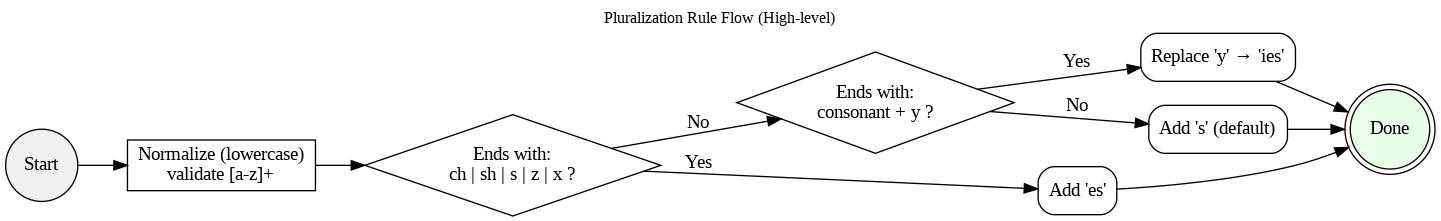

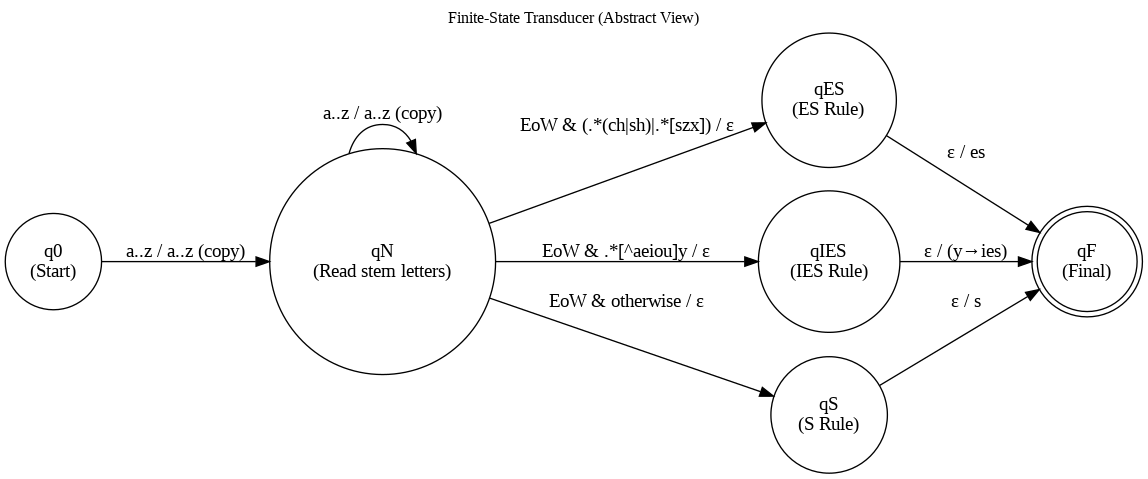

,root,rule_used,output
0,cat,S,cats
1,try,IES,tries
2,boy,S,boys
3,fox,ES,foxes
4,bus,ES,buses
5,watch,ES,watches
6,hero,S,heros
7,buzz,ES,buzzes
8,day,S,days
9,church,ES,churches


In [ ]:
# ✅ Colab-ready: Visualize the pluralization FST + rule flowchart in one go

# 1) Install deps
!apt-get -qq install -y graphviz > /dev/null
!pip -q install graphviz > /dev/null

# 2) Imports
from graphviz import Digraph
from IPython.display import display, Image
import re
import pandas as pd
import os

# 3) Define the pluralization rules (same logic as your code)
def apply_rule(word: str):
    w = word.lower()
    if re.search(r"(ch|sh)$", w) or re.search(r"(s|z|x)$", w):
        return "ES", w + "es"
    if re.search(r"[^aeiou]y$", w):
        return "IES", w[:-1] + "ies"
    return "S", w + "s"

# 4) Build a *flowchart* of rule selection
flow = Digraph("Plural_Flowchart", format="png")
flow.attr(rankdir="LR", fontsize="12", labelloc="t", label="Pluralization Rule Flow (High-level)")

flow.node("start", "Start", shape="circle", style="filled", fillcolor="#f0f0f0")
flow.node("norm", "Normalize (lowercase)\nvalidate [a-z]+", shape="box")
flow.node("r1", "Ends with:\nch | sh | s | z | x ?", shape="diamond")
flow.node("r2", "Ends with:\nconsonant + y ?", shape="diamond")
flow.node("es", "Add 'es'", shape="box", style="rounded")
flow.node("ies", "Replace 'y' → 'ies'", shape="box", style="rounded")
flow.node("s", "Add 's' (default)", shape="box", style="rounded")
flow.node("done", "Done", shape="doublecircle", style="filled", fillcolor="#e8ffe8")

flow.edge("start", "norm")
flow.edge("norm", "r1")
flow.edge("r1", "es", label="Yes")
flow.edge("r1", "r2", label="No")
flow.edge("r2", "ies", label="Yes")
flow.edge("r2", "s", label="No")
flow.edge("es", "done")
flow.edge("ies", "done")
flow.edge("s", "done")

flow_path = "/content/plural_flowchart"
flow.render(flow_path, cleanup=True)
display(Image(filename=flow_path + ".png"))

# 5) Build an *abstract Mealy-style FST* view (rule-guarded suffix transitions)
#    This is not a full character-by-character transducer; it shows how the rule branch decides the output.
fst = Digraph("Plural_FST", format="png")
fst.attr(rankdir="LR", fontsize="12", labelloc="t", label="Finite-State Transducer (Abstract View)")

# States
fst.node("q0", "q0\n(Start)", shape="circle")
fst.node("qN", "qN\n(Read stem letters)", shape="circle")
fst.node("qES", "qES\n(ES Rule)", shape="circle")
fst.node("qIES", "qIES\n(IES Rule)", shape="circle")
fst.node("qS", "qS\n(S Rule)", shape="circle")
fst.node("qF", "qF\n(Final)", shape="doublecircle")

# Edges (labels: input/output)
# We show that letters pass through unchanged while scanning to the end (abstracted).
fst.edge("q0", "qN", label="a..z / a..z (copy)")
fst.edge("qN", "qN", label="a..z / a..z (copy)")

# Branch on end-of-stem with guards (regex conditions shown as predicates)
fst.edge("qN", "qES", label="EoW & (.*(ch|sh)|.*[szx]) / ε")
fst.edge("qN", "qIES", label="EoW & .*[^aeiou]y / ε")
fst.edge("qN", "qS", label="EoW & otherwise / ε")

# Emit suffixes
fst.edge("qES", "qF", label="ε / es")
fst.edge("qIES", "qF", label="ε / (y→ies)")
fst.edge("qS", "qF", label="ε / s")

fst_path = "/content/plural_fst"
fst.render(fst_path, cleanup=True)
display(Image(filename=fst_path + ".png"))

# 6) Tiny simulation table to see which rule triggers (for quick sanity check)
sample_words = ["cat", "try", "boy", "fox", "bus", "watch", "hero", "buzz", "day", "church", "dish", "toy"]
rows = []
for w in sample_words:
    rule, plural = apply_rule(w)
    rows.append({"root": w, "rule_used": rule, "output": plural})

df = pd.DataFrame(rows)
df
